# Classification

Loading standard libraries

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Loading internal abstractions

In [2]:
sys.path.append('..')
from kernel import KernelComputer, KernelRegressor
from dataloader import MULANLoader, FoldsGenerator

Randomness reproducibility

In [3]:
np.random.seed(0)

### Choose datasets to play with

In [4]:
names = MULANLoader.datasets
names = ['scene']

### Choose a kernel

In [5]:
kernel = 'Gaussian'  # 'Gaussian', 'Laplacian', 'Linear'

### Choose hyparameters for the simulations

In [6]:
nb_folds = 8                                              # number of folds
corruptions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]          # corruptions to test
sigmas = [1e1, 5e0, 1e0, 5e-1, 1e-1, 1e-2]                # different kernel parameters to test
lambdas = [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3]          # different regularizations to test

Internal main script

In [7]:
import numba


@numba.jit(nopython=True)
def Hamming_loss(A, B):
    d = np.zeros((A.shape[0], B.shape[0]), dtype=np.float64)
    for i in range(A.shape[0]):
        for j in range(B.shape[0]):
            for k in range(5):
                if A[i, k] != B[j, k]:
                    d[i, j] += 1
    return d


def get_y_grid(m):
    y_grid = np.zeros((2**m, m))
    for i in range(2**m):
        tmp = np.base_repr(i, 2)
        for j in range(len(tmp)):
            y_grid[i, -j-1] = int(tmp[-j-1])
    return y_grid


def add_corruption(y_train, corruption):
    n_train, m = y_train.shape
    r_train = (corruption * (m + 1) * np.random.rand(n_train)).astype(np.int64)
    offset = (m * np.random.rand(n_train, m)).astype(np.int64)
    for i in range(n_train):
        offset[i] = np.isin(np.arange(m), offset[i, :r_train[i]]).astype(np.int)
    c_train = y_train + offset
    c_train %= 2
    return c_train, r_train

In [8]:
_kernel = KernelComputer(kernel, sigma=1)
kernel_reg = KernelRegressor(_kernel)

err_ac, err_il, err_sp = {}, {}, {}
shape_err = (len(corruptions), nb_folds, len(sigmas), len(lambdas))

for name in names:
    print(name)
    
    loader = MULANLoader(name)
    x, y = loader.get_trainset()
    
    ind = y.sum(axis=0) != 0
    y = y[:, ind]
    y_grid = get_y_grid(ind.sum())

    loss_shape = (y.shape[0], 2**y.shape[-1], len(corruptions))
    AC_loss, IL_loss, SP_loss = np.empty(loss_shape), np.empty(loss_shape), np.empty(loss_shape)
    for i_c, corruption in enumerate(corruptions):
        c, r = add_corruption(y, corruption)
        
        _loss = Hamming_loss(c, y_grid)
        _loss -= r[:, np.newaxis]
        _loss[_loss < 0] = 0
        IL_loss[..., i_c] = _loss
        
        S = Hamming_loss(c, y_grid) <= r[:, np.newaxis]
        center = S / S.sum(axis=1)[:, np.newaxis]
        center = center @ y_grid
        AC_loss[..., i_c] = Hamming_loss(center, y_grid)
        
        loss = Hamming_loss(y_grid, y_grid)
        for i in range(len(SP_loss)):
            SP_loss[i, :, i_c] = loss[S[i]].max(axis=0)
        
    S = np.stack((IL_loss, AC_loss, SP_loss), axis=-1)

    err_ac[name]= np.empty(shape_err)
    err_il[name]= np.empty(shape_err)
    err_sp[name]= np.empty(shape_err)
    
    floader = FoldsGenerator(x, y, S, nb_folds=nb_folds)
    
    for fold in range(nb_folds):

        (x_train, S_train), (x_test, y_test) = floader()
        kernel_reg.set_support(x_train)
        n_train, dim = x_train.shape
        
        for i_s, c_sigma in enumerate(sigmas):
            sigma = c_sigma * dim
            kernel_reg.update_sigma(sigma)

            for i_l, c_lambda in enumerate(lambdas):
                lambd = c_lambda / np.sqrt(n_train)
                kernel_reg.update_lambda(lambd)
                alpha = kernel_reg(x_test)

                for i_c, corruption in enumerate(corruptions):
                    
                    IL_loss = S_train[..., i_c, 0]
                    AC_loss = S_train[..., i_c, 1]
                    SP_loss = S_train[..., i_c, 2]
                    
                    loss_grid = alpha @ AC_loss
                    y_ac = y_grid[np.argmin(loss_grid, axis=1), :]

                    loss_grid = alpha @ IL_loss
                    y_il = y_grid[np.argmin(loss_grid, axis=1), :]

                    loss_grid = alpha @ SP_loss
                    y_sp = y_grid[np.argmin(loss_grid, axis=1), :]

                    err_ac[name][i_c, fold, i_s, i_l] = ((y_ac - y_test) != 0).mean()
                    err_il[name][i_c, fold, i_s, i_l] = ((y_il - y_test) != 0).mean()
                    err_sp[name][i_c, fold, i_s, i_l] = ((y_sp - y_test) != 0).mean()

scene


In [9]:
n_c = len(corruptions)
mus, stds = np.empty((len(names), 3, n_c)), np.empty((len(names), 3, n_c))
for i, name in enumerate(names):
    for j, err in zip([0,1,2], [err_ac, err_il, err_sp]):
        tmp = err[name].reshape((len(corruptions), nb_folds, -1))
        mu = tmp.mean(axis=-1)
        ind = mu.argmin(axis=1)
        for k in range(len(corruptions)):
            mus[i, j, k] = mu[k, ind[k]]
            stds[i, j, k] = tmp[k, ind[k]].std()

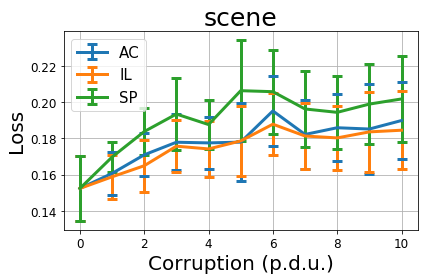

In [10]:
for i, name in enumerate(names):
    fig, ax = plt.subplots()
    a = ax.errorbar([i for i in corruptions[:]], mus[i, 0][:], .5*stds[i, 0][:], capsize=5, linewidth=3, capthick=3)
    b = ax.errorbar([i for i in corruptions[:]], mus[i, 1][:], .5*stds[i, 1][:], capsize=5, linewidth=3, capthick=3)
    c = ax.errorbar([i for i in corruptions[:]], mus[i, 2][:], .5*stds[i, 2][:], capsize=5, linewidth=3, capthick=3)
    ax.legend([a, b, c], ['AC', "IL", "SP"], prop={'size':15})
    ax.grid()
    ax.set_title(name, size=25)
    ax.set_ylabel('Loss', size=20)
    ax.set_xlabel('Corruption (p.d.u.)', size=20)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    fig.savefig(name + '.pdf')